# グリコゲームの数値解を求める

Qiita記事 → https://qiita.com/yasagureprog/items/26d34a791180b447e0db

# 求解クラスを作成

## パラメータの設定

必要ライブラリのインポート、matplotlibの設定を行う

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
config = {
    'font.family':'Yu Mincho',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'font.size': 14,
    'axes.linewidth': 1.0,
    'figure.dpi': 144
}
plt.rcParams.update(config)

## 求解条件を作成

- length ... 階段の高さ
- rewards ... 自分&相手の出した手に対応した、進める段数の定義行列

In [29]:
length = 5
rewards = np.array([
            [-1, 1, 0], # グー
            [0, -1, 2], # チョキ
            [2, 0, -1]  # パー
        ])

## ソルバークラスを作成

In [30]:
class Solver:
    def __init__(self, length, rewards):
        self.length = length
        self.rewards = rewards
        self.hand_size = rewards.shape[0]

    def make_init(self):
        V = np.zeros(self.length*self.length)
        H = np.full(self.length*self.length*(self.hand_size-1), 1/3)
        return np.append(V, H, axis=0)

    def make_equations(self, x):
        unit = self.length**2
        V = np.zeros((self.length+1, self.length+1))
        V[1:, 1:] = x[:unit].reshape((self.length, self.length))
        V[:, 0] -= 1
        V[0, :] += 1

        H = x[unit:].reshape((self.hand_size-1, self.length, self.length))
        H = np.vstack([H, [1-H.sum(axis=0)]])
        R = np.zeros((self.hand_size, self.length, self.length))
        for i in range(1, self.length+1):
            for j in range(1, self.length+1):
                range_func = lambda k, rws: np.where(k-rws <= 0, 0, np.where(k-rws >= self.length, self.length, k-rws))
                x = V[range_func(i, rewards), range_func(j, rewards.T)] @ H[:,j-1,i-1].T - V[i,j]
                R[:,i-1,j-1] = x
        R = R.reshape(self.hand_size*self.length**2)
        return R

    def solve(self):
        self.result = optimize.root(self.make_equations, self.make_init(), method="lm")
        x = self.result["x"]
        unit = self.length**2
        self.V = x[:unit].reshape((self.length, self.length))
        self.H = x[unit:].reshape((self.hand_size-1, self.length, self.length))
        self.H = np.vstack([self.H, [1-self.H.sum(axis=0)]])

        if self.result["success"] == False: raise Exception("cannot find variable solution")


## 求解
- stair_length = 階段の段数
- hands_num = 出せる手の数(グーチョキパーなら3)
- rewards = 大きさ(hands_num, hands_num)のリスト。双方が出した手ごとに、(自分が進む歩数, 相手が進む歩数)を指定する。

In [31]:
solver = Solver(length, rewards)

solver.solve()

## プロット
- qg_list, qc_list指定で色付け
- 指定なしで期待利得のみ描画

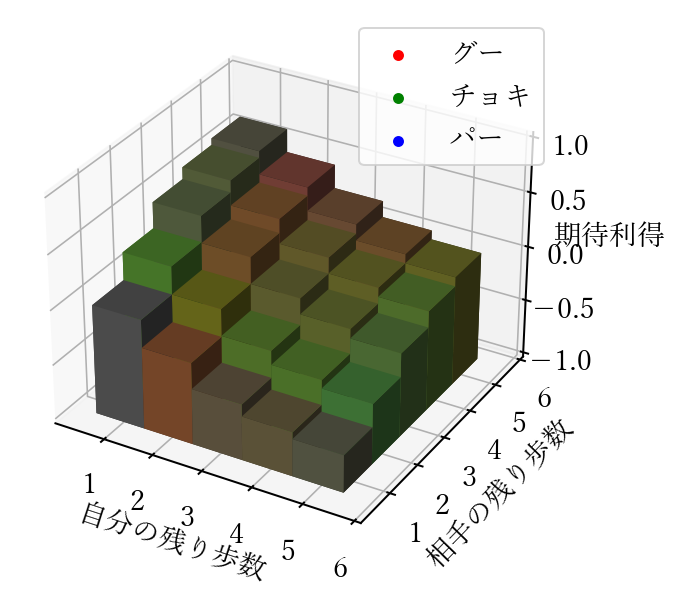

In [32]:
def plot_guriko(V, H):
    length = V.shape[0]
    x, y = np.meshgrid(np.arange(length), np.arange(length))
    x, y = x.ravel(), y.ravel()
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    rfunc = lambda x: min(max(x, 0), 1)
    C = np.array([(rfunc(i), rfunc(j), rfunc(k)) for i, j, k in zip(H[0].T.ravel(), H[1].T.ravel(), H[2].T.ravel())])
    ax.bar3d(x+0.5, y+0.5, np.zeros_like(x)-1, 1, 1, V.T.ravel()+1, color=C)

    ax.scatter([], [], color="r", label="グー")
    ax.scatter([], [], color="g", label="チョキ")
    ax.scatter([], [], color="b", label="パー")
    ax.legend()

    ax.set_zlim(-1, 1)
    ax.set_xlim(0.1, length+1)
    ax.set_ylim(0.1, length+1)
    ax.set_xlabel("自分の残り歩数")
    ax.set_ylabel("相手の残り歩数")
    ax.set_zlabel("期待利得")

plot_guriko(solver.V, solver.H)

## 様々な条件で求解

### ①グーで勝てば10歩、チョキは2歩、パーは1歩だけ

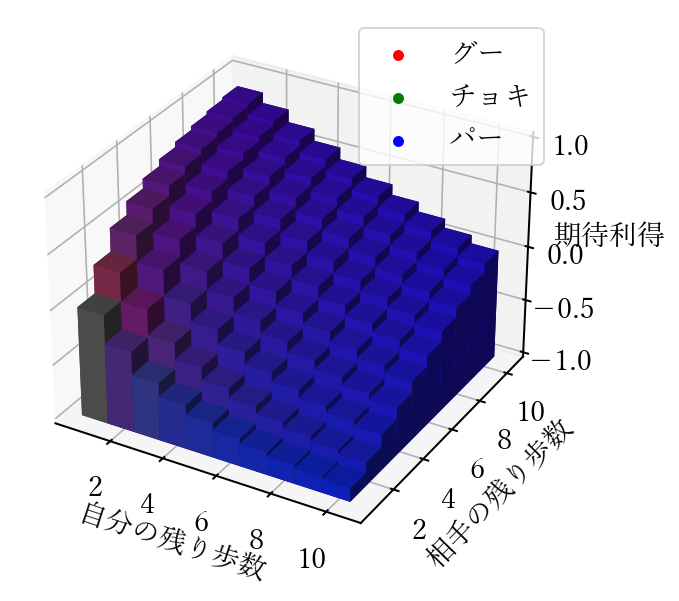

In [33]:
length = 10
rewards = np.array([
    [0, 10, 0],
    [0, 0, 2],
    [1, 0, 0]
])

solver = Solver(length, rewards)
solver.solve()

plot_guriko(solver.V, solver.H)

### ②グリコゲームだが負けたらふりだしに戻る

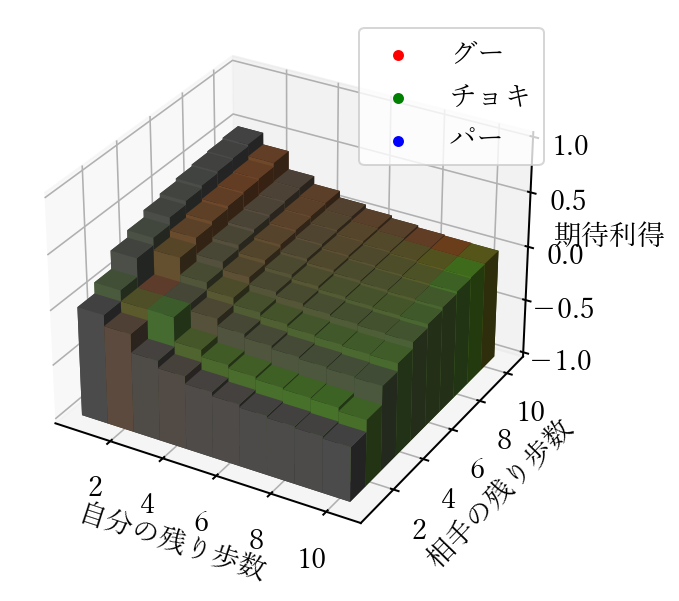

In [34]:
stair_length = 10
rewards = np.array([
    [0, 1, -100],
    [-100, 0, 2],
    [2, -100, 0]
])

solver = Solver(length, rewards)
solver.solve()

plot_guriko(solver.V, solver.H)

# テンプレート

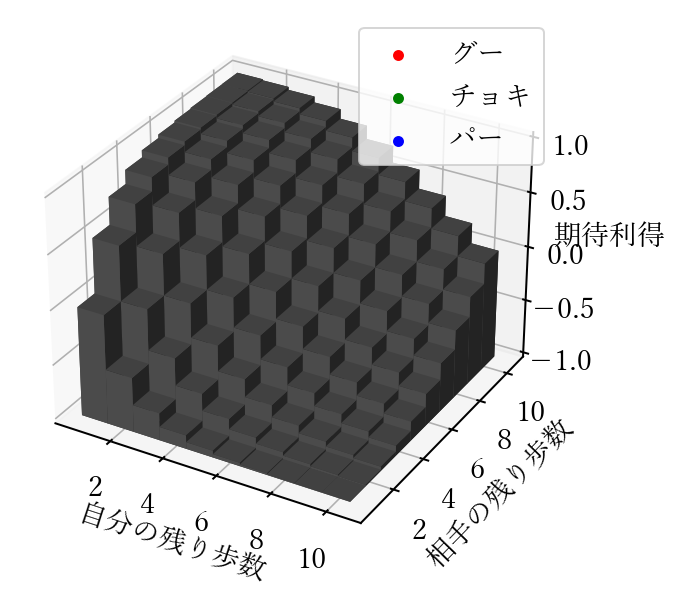

In [35]:
stair_length = 10
rewards = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
])

solver = Solver(length, rewards)
solver.solve()

plot_guriko(solver.V, solver.H)